# WSI 24L
## Ćwiczenie 2 - algorytm genetyczny, optymalizacja układu dróg i miejsc parkingowych
### Igor Szabłowski

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import choices
import seaborn as sns

### Implementacja algorytmu
Zaimplementowany został algorytm genetyczny z selekcją ruletkową, krzyżowaniem jednopunktowym, mutacją oraz sukcesją generacyjną. Implementacja ta wykorzystuje prawdopodobieństwo krzyżowania oraz mutacji, populacje początkową oraz budżet (ilość pokoleń przez które chcemy przejść). Sprawdzanym problemem jest optymalizacja układu dróg i miejsc parkingowych, którego funkcja oceny została nam zadana.

In [2]:
class GeneticAlgorithm:

    def __init__(self, pc, pm):
        self._pc = pc
        self._pm = pm

    def get_parameters(self):
        return {'pc': self._pc,'pm': self._pm}

    def solve(self, pop0, q, t_max):
        t = 0
        best_route = []
        population = pop0
        if any(any(i not in [0, 1] for i in gene) or not np.sum(gene) for gene in population):
            raise ValueError('expected gene of 0 and 1')
        population_values = [q(x) for x in pop0]
        value_best = np.max(population_values)
        x_best = population[np.argmax(population_values)]
        while t < t_max:
            population = self._selection(population, population_values)
            population = self._crossover(population, self._pc)
            population = self._mutation(population, self._pm)
            if any(not np.sum(gene) for gene in population):
                raise ValueError('gene cant have only zeros')
            population_values = [q(x) for x in population]
            new_population_value_best = np.max(population_values)
            if new_population_value_best > value_best:
                x_best = population[np.argmax(population_values)]
                value_best = new_population_value_best
            t += 1
            best_route.append(value_best)
        return x_best, value_best, best_route

    def _selection(self, population, population_values):
        values_sum = np.sum(population_values)
        pi_values = [value/values_sum for value in population_values]
        return choices(population, pi_values, k=len(population))
    
    def _crossover(self, population, pc):
        population_after_crossover = []
        while population:
            random_chance = np.random.random()
            if random_chance <= pc:
                crossover_point = np.random.choice(len(population[0])-1)
                first_parent_population = population.pop(0)
                second_parent_population = population.pop(0)
                first_child_population = np.array(list(first_parent_population[:crossover_point]) + list(second_parent_population[crossover_point:]))
                second_child_population = np.array(list(second_parent_population[:crossover_point]) + list(first_parent_population[crossover_point:]))
                population_after_crossover.append(first_child_population)
                population_after_crossover.append(second_child_population)
            else:
                population_after_crossover.append(population.pop(0))
                population_after_crossover.append(population.pop(0))
        return population_after_crossover

    def _mutation(self, population, pm):
        for index_x, x in enumerate(population):
            for index_gene, gene in enumerate(x):
                random_chance = np.random.random()
                if random_chance <= pm:
                    switched_gene = 1 if not gene else 0
                    population[index_x][index_gene] = switched_gene
        return population


def evaluate(x):
    n = int(len(x) ** (0.5))
    checked = [[False] * n for _ in range(n)]
    avaliable = [[False] * n for _ in range(n)]
    to_check = []
    for i in range(n):
        to_check.append((i, 0))
        to_check.append((i, n - 1))
        to_check.append((0, i))
        to_check.append((n - 1, i))
    while to_check:
        i, j = to_check.pop()
        if checked[i][j]:
            continue
        checked[i][j] = True
        if x[i * n + j]:
            avaliable[i][j] = True
        else:
            if i > 0:
                to_check.append((i - 1, j))
            if i < n - 1:
                to_check.append((i + 1, j))
            if j > 0:
                to_check.append((i, j - 1))
            if j < n - 1:
                to_check.append((i, j + 1))
    return sum(sum(row) for row in avaliable)


In [3]:
def prepare_for_heatmap(x):
    n = int(len(x) ** (0.5))
    checked = [[False] * n for _ in range(n)]
    avaliable = [[0.5 if gene else 0 for gene in x_row] for x_row in np.array(x).reshape((n, n))]
    to_check = []
    for i in range(n):
        to_check.append((i, 0))
        to_check.append((i, n - 1))
        to_check.append((0, i))
        to_check.append((n - 1, i))
    while to_check:
        i, j = to_check.pop()
        if checked[i][j]:
            continue
        checked[i][j] = True
        if x[i * n + j]:
            avaliable[i][j] = 1
        else:
            if i > 0:
                to_check.append((i - 1, j))
            if i < n - 1:
                to_check.append((i + 1, j))
            if j > 0:
                to_check.append((i, j - 1))
            if j < n - 1:
                to_check.append((i, j + 1))
    return avaliable

Poniżej został przedstawiony wynik przykładowego uruchomienia algorytmu, czyli najlepszy osobnik. Został on przedstawiony w formie heatmapy (zielone - miejsca z możliwością dostępu, czerwone - miejsca bez możliwości dostępu, białe - droga) oraz przebieg wartości najleszego na dany moment osobnika. Dobrane do uruchomienia prawdopodobieństwa zostały dobrane na zasadzie tego, że głownym napędem ewolucji jest krzyżowanie, więc powinno być blisko jedności, natomiast mutacja powinna wynosić około $1/n$ gdzie n jest naszym wymiarem problemu (100). Postanowiłem zostawić krzyżowaniu główną część ewolucji, natomiast mutacji dałem nieznacznie większe znaczenie niż $1/n$. Jak można zauważyć wynik od początkowego najlepszego osobnika został poprawiony o 7 punktów, i zostało to osiągnietę w mniej niż 200 iteracjach. Nie oznacza to oczywiście tego że zwiększanie budżetu nic nie daje, ponieważ może być sytuacja że w ostatniej iteracji zostanie znaleziony lepszy osobnik, natomiast w większości przypadków zostawał on znajdywany w pierwszej połowie przebiegu. 

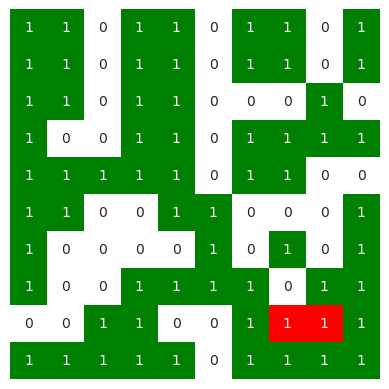

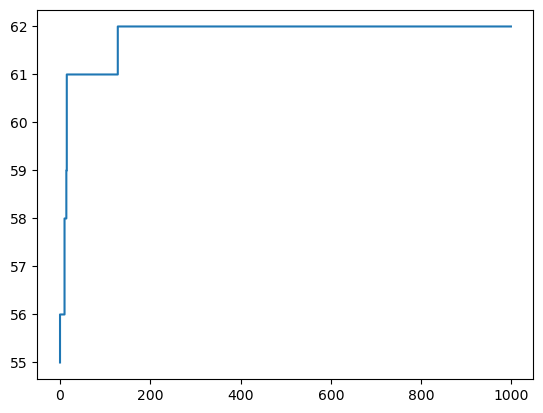

In [4]:
x = np.random.randint(0, 2, (1000, 100))
solver = GeneticAlgorithm(0.99, 0.015)
t_max = 1000

x, values, best_route = solver.solve(x, evaluate, t_max)
x_data = prepare_for_heatmap(x)
sns.heatmap(x_data, annot=np.array(x).reshape((10, 10)), cmap=['white', 'red', 'green'], cbar=False, square=True, xticklabels='', yticklabels='')

plt.show()
plt.step(np.arange(t_max), best_route)
plt.show()



Postanowiłem zbadać tą implementacje poprzez zmienianie prawdopodobieństwa krzyżowania. Każda wartość tego parametru została przetestowana dla 25 prób, dla rozmiaru populacji 100 oraz budżetu 1000. Jak można zauważyć różnice są znaczne i widoczny jest wzrost wartości wraz ze wzrostem prawdopodobieństwa krzyżowania. Potwierdza to wcześniej wspomniane założenia.

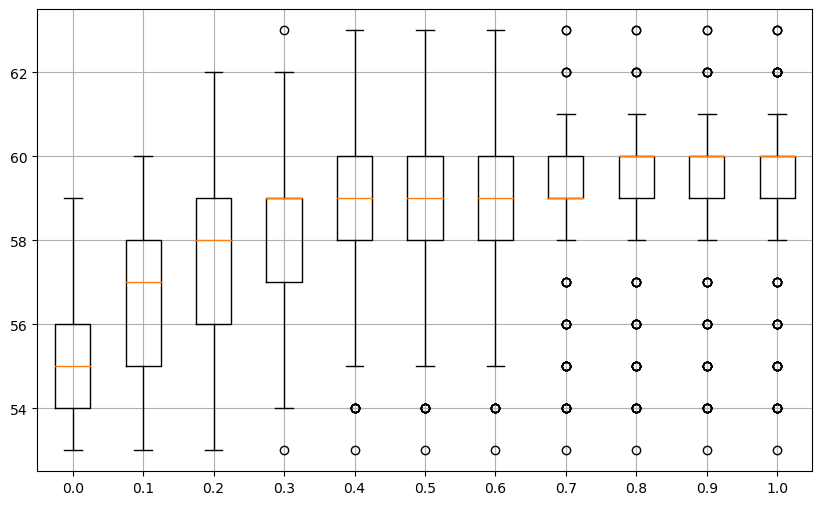

In [5]:
t_max = 1000
pc_array = np.arange(0, 1.01, 0.1)
results_x = []
result = []
for pc in pc_array:
    for _ in range(25):
        x = np.random.randint(0, 2, (100, 100))
        solver = GeneticAlgorithm(pc, 0.015)
        x, values, best_route = solver.solve(x, evaluate, t_max)
        results_x.append((x, values))
    result_values = [result_x[1] for result_x in results_x]
    result.append(result_values)
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.boxplot(result)
plt.xticks(np.arange(1, 12), np.round(pc_array, 1))
plt.show()


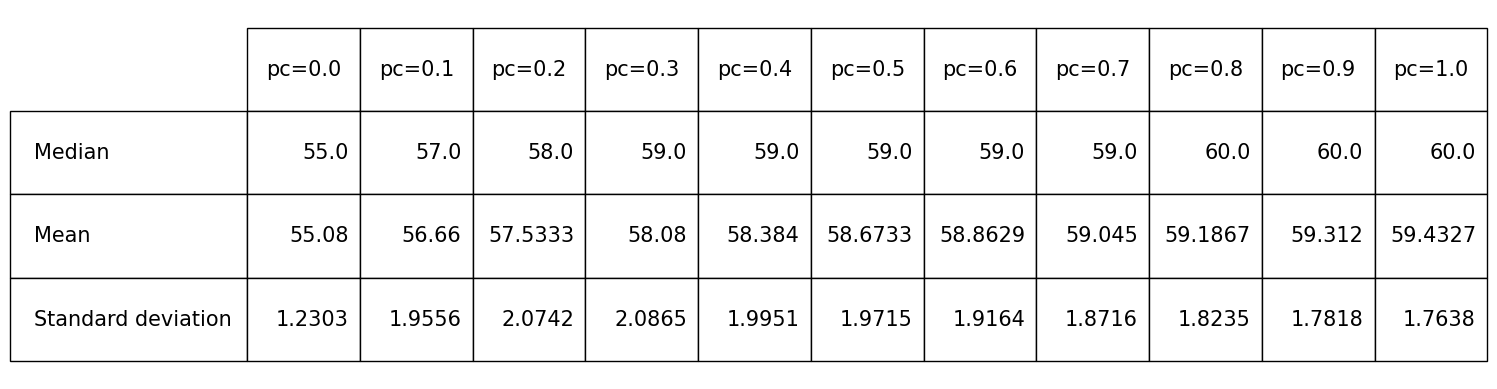

In [6]:
row_labels = ['Median', "Mean", 'Standard deviation']
column_labels = [f'pc={np.round(pc, 1)}' for pc in pc_array]
median = [np.median(values) for values in result]
mean = [np.mean(values) for values in result]
std_dev = [np.std(values) for values in result]
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=[median, np.round(mean, 4), np.round(std_dev, 4)], rowLabels=row_labels, colLabels=column_labels, loc='center')
table.set_fontsize(15)
table.scale(2.5, 5)
plt.show()

Aby zbadać dokładniej przedział prawdopodobobieństwa krzyżowania w zakresach w których implementacja radzi sobie najlepiej powtórzyłem tę próbę dla przedziału od 0.9 do 0.99 włącznie. Jak można zauważyć poradził sobie bardzo dobrze na zadanych prawdopodobieństwach, różnice są nieznaczne. Dla każdego prawdopodobieństwa mediana wynosiła 60, a średnia około 60. Najlepszy wynik dało prawdopodobieństwo równe 0.99 z najwyższą średnią.

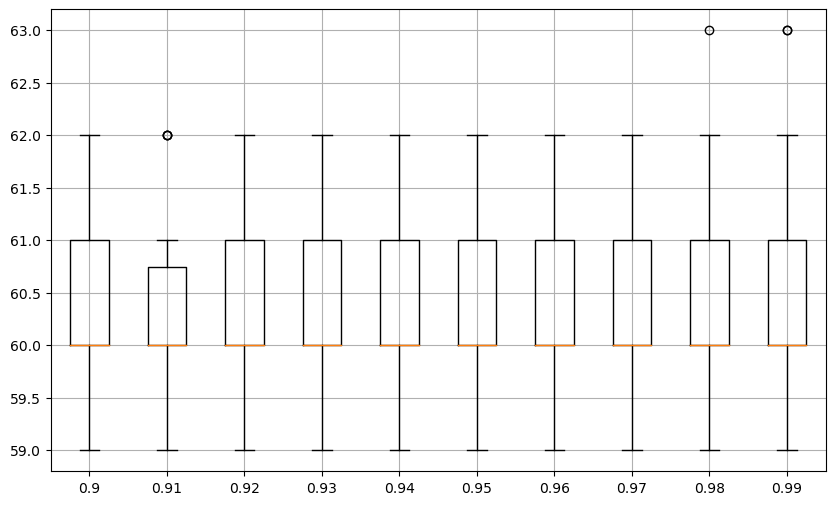

In [7]:
t_max = 1000
pc_array = np.arange(0.9, 1, 0.01)
results_x = []
result = []
for pc in pc_array:
    for _ in range(25):
        x = np.random.randint(0, 2, (100, 100))
        solver = GeneticAlgorithm(pc, 0.015)
        x, values, best_route = solver.solve(x, evaluate, t_max)
        results_x.append((x, values))
    result_values = [result_x[1] for result_x in results_x]
    result.append(result_values)
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.boxplot(result)
plt.xticks(np.arange(1, 11), np.round(pc_array, 2))
plt.show()

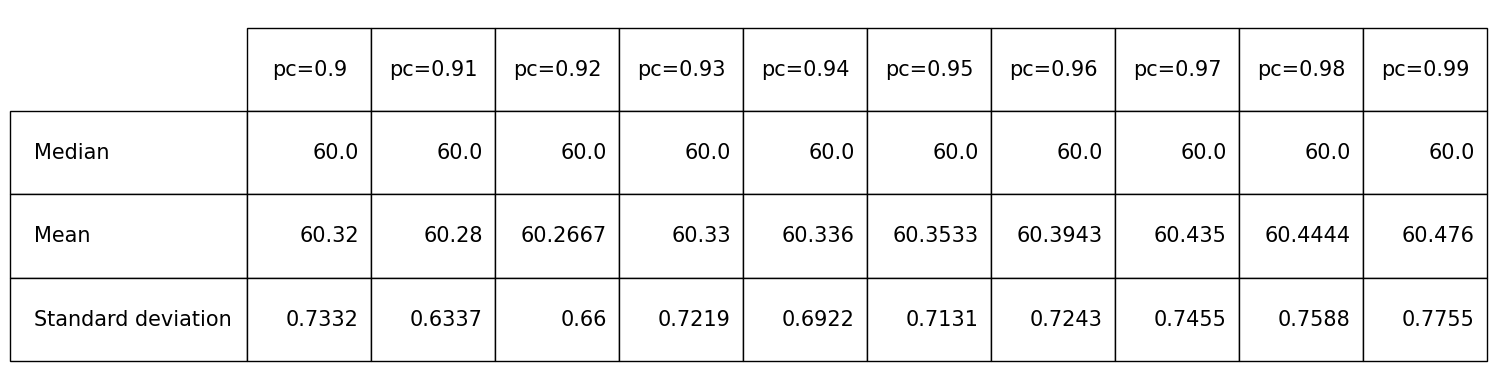

In [8]:
row_labels = ['Median', "Mean", 'Standard deviation']
column_labels = [f'pc={np.round(pc, 2)}' for pc in pc_array]
median = [np.median(values) for values in result]
mean = [np.mean(values) for values in result]
std_dev = [np.std(values) for values in result]
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=[median, np.round(mean, 4), np.round(std_dev, 4)], rowLabels=row_labels, colLabels=column_labels, loc='center')
table.set_fontsize(15)
table.scale(2.5, 5)
plt.show()

### Wnioski końcowe
Podczas korzystania z takiej implementacji algorytmu genetycznego powinniśmy skupić się na odpowiednim doborze wartości prawdopodobieństw krzyżowania oraz mutacji. Z badania wartości prawdopodobieństw krzyżowania dowiedziliśmy się, że coraz większe wartości dawały coraz to lepsze wyniki ze względu na to że dobre osobniki krzyżowały się z dobrymi osobnikami, co zapewmniała nam selekcja. Dobór budżetu jest także ważnym punktem, natomiast odpowiedzią na to ile powinno się go dawać jest to ile czasu możemy poświęcić na to aby nasz algorytm szukał najlepszego osobnika. Jeśli chodzi o rozmiar populacji początkowej, z założenia powinien być on większy niż wymiar problemu, natomiast wykonywane są też eksperymenty na mniejszych populacjach.